<a href="https://colab.research.google.com/github/LoniQin/deep_learning_notebooks/blob/master/tensorflow/Stock_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
from pandas_datareader.data import DataReader
from datetime import datetime

## Load data
We predict the stock price of apple here. If we want to predict other stocks, we can simply change the symbol and company name.

In [39]:
symbol = 'TSLA'
company_name = 'TESLA'
end = datetime.now()
start = datetime(2012, end.month, end.day)
stock_data = DataReader(symbol, 'yahoo', start, end)

In [40]:
stock_data.tail(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-03-12,694.880005,666.140015,670.000000,693.729980,33583800.0,693.729980
2021-03-15,713.179993,684.039978,694.090027,707.940002,29335600.0,707.940002
2021-03-16,707.919983,671.000000,703.349976,676.880005,31903400.0,676.880005
2021-03-17,703.729980,651.010010,656.869995,701.809998,40083300.0,701.809998
2021-03-18,689.229980,652.000000,684.289978,653.159973,33224800.0,653.159973
2021-03-19,657.229980,624.619995,646.599976,654.869995,42827400.0,654.869995
2021-03-22,699.619995,668.750000,684.590027,670.000000,39512200.0,670.000000
2021-03-23,677.799988,657.510010,675.770020,662.159973,30491900.0,662.159973
2021-03-24,668.020020,630.109985,667.909973,630.270020,33684600.0,630.270020


In [41]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2265 entries, 2012-03-26 to 2021-03-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2265 non-null   float64
 1   Low        2265 non-null   float64
 2   Open       2265 non-null   float64
 3   Close      2265 non-null   float64
 4   Volume     2265 non-null   float64
 5   Adj Close  2265 non-null   float64
dtypes: float64(6)
memory usage: 123.9 KB


Text(0.5, 1.0, 'TESLA')

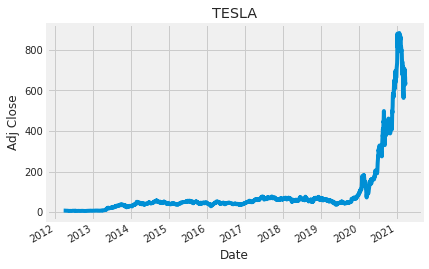

In [42]:
stock_data["Adj Close"].plot()
plt.ylabel("Adj Close")
plt.title(company_name)

## Calculate moving average of the stock

In [43]:
for ma in [10, 20, 50]:
  stock_data[f"MA for {ma} days"] = stock_data['Adj Close'].rolling(ma).mean()

In [44]:
stock_data.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'MA for 10 days',
       'MA for 20 days', 'MA for 50 days'],
      dtype='object')

## Show histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed30dd0750>,
      dtype=object)

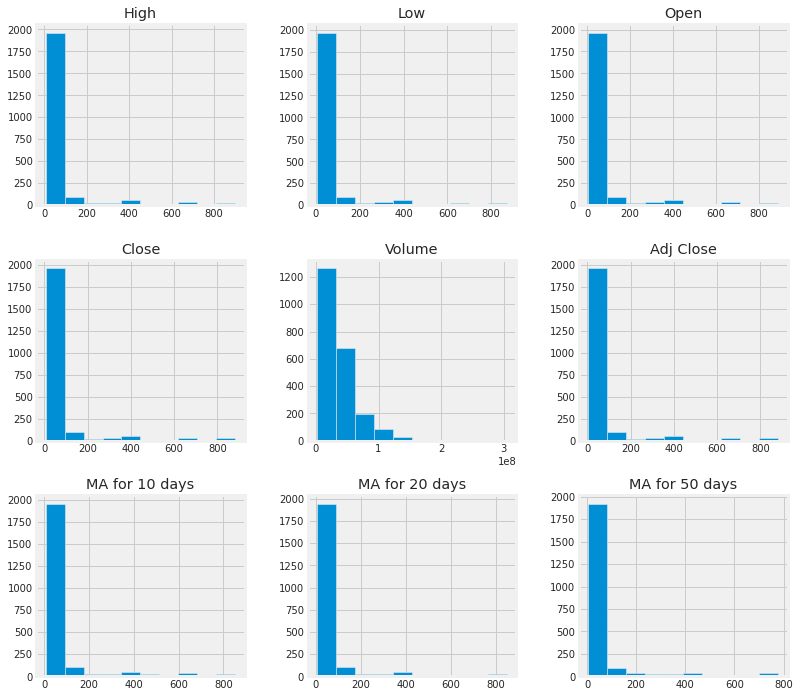

In [45]:
stock_data.hist(figsize=(12, 12))

## 

Text(0.5, 1.0, 'TESLA')

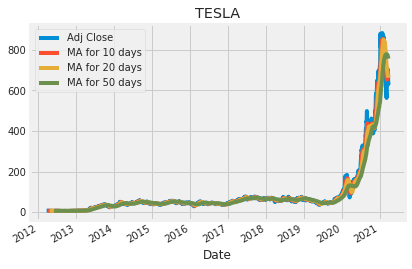

In [46]:
stock_data[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title(company_name)

## Calcuate daily return

In [47]:
stock_data["Daily Return"] = stock_data["Adj Close"].pct_change()

Text(0.5, 1.0, 'TESLA')

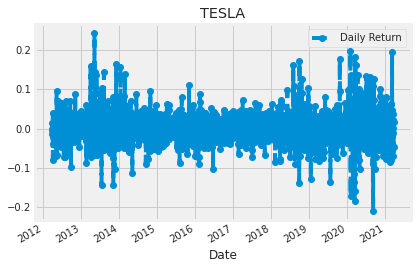

In [48]:
stock_data["Daily Return"].plot(legend=True, linestyle='--', marker='o')
plt.title(company_name)

In [49]:
# Create a new dataframe with only the 'Close column 
data = stock_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2152

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00257441],
       [0.00269744],
       [0.00267693],
       ...,
       [0.74833398],
       [0.71200747],
       [0.72326769]])

In [51]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [52]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [53]:
x_train.shape

(2092, 60, 1)

## Build the model

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential([
  LSTM(128, return_sequences=True, input_shape = (x_train.shape[1], 1)),
  LSTM(64, return_sequences=False),
  Dense(25),
  Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 128)           66560     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1625      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [58]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

2092/2092 [==============================] - 60s 29ms/step - loss: 4.3415e-04


## Predict data

In [59]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
rmse

69.60761751017333

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


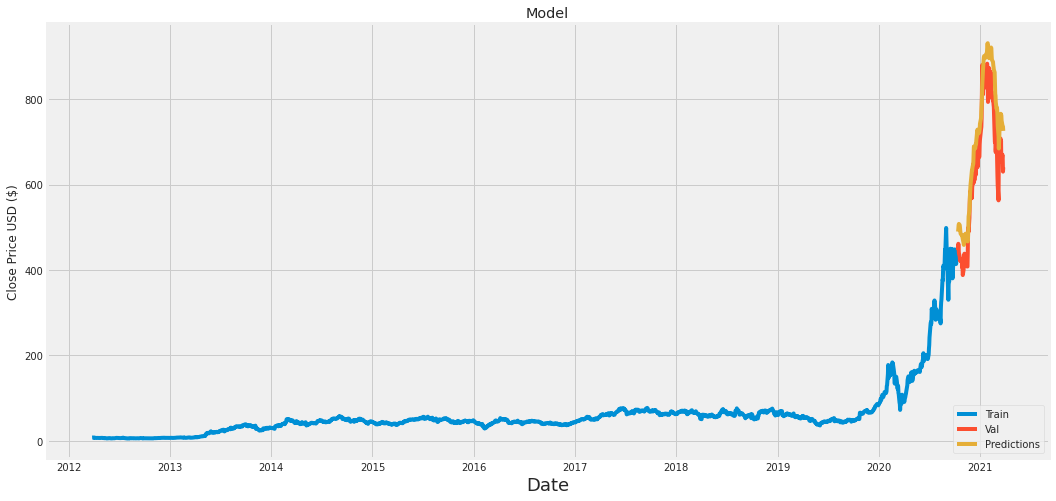

In [60]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()